# Vortex patch dynamics

In [976]:
 using FluidDynTools 

In [977]:
using PotentialFlow

In [978]:
using Plots

### Create the vortex evolution function
The following defines the function to compute the velocities of all vortex elements in the system

In [979]:
function compute_ẋ!(ẋ, x, t)
        
    # Zero the velocity
    reset_velocity!(ẋ, x)
    
    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)
    
end

compute_ẋ! (generic function with 1 method)

### Set up initial vortices

Now we will set up the vortex elements in the physical plane. Let's first set up some functions that create a circular patch of point vortices of specified position, size, and strength.

In [980]:
"""
    vortex_patch!(vort,zc,Γ,radius,nring[,ϵ=0])

Create a circular patch of vortex blobs, returned in `vort`. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `ϵ`, which is 0 by default.
"""
function vortex_patch!(vort,zc,Γ,radius,nring::Int;ϵ=0)
    Δr = radius/(nring-1/2)
    dΓ = Γ/(1+8*nring*(nring-1)/2)
    push!(vort,Vortex.Blob(zc,dΓ,ϵ))
    for ir in 1:nring-1
        nθ = 8*ir
        for j = 0:nθ-1
            push!(vort,Vortex.Blob(zc + ir*Δr*exp(im*2π*j/nθ),dΓ,ϵ))
        end
    end
    return vort
end

"""
    vortex_patch(zc,Γ,radius,nring[,δ=0]) -> Vector{Vortex.Blob}

Create a circular patch of vortex blobs. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `δ`, which is 0 by default.
"""
vortex_patch(zc,Γ,radius,nring::Int;ϵ=0) = vortex_patch!(Vortex.Blob{Float64,Float64}[],zc,Γ,radius,nring,ϵ=ϵ)

vortex_patch

We will set up two patches for this demonstration. Each will have 10 rings. You can play with any of these.

In [981]:
r01 = r02 = 0.293 # initial radius of the vortex patch

d0 = 1.0  # initial distance between patch centroids

Γ01 = Γ02 = 1.0 # strength of patch.

nring = 10   # number of rings in each patch.

ϵ = 0.02 # blob radius

Δt = 0.01*π^2*d0^2/abs(Γ01) # set the time step
nothing

Initialize the system and the velocity structure. Any time you wish to restart a problem, you will need to run the next two input lines. The system here is composed of two patches, one initially at $(0,0.5d_0)$ and the other at $(0,-0.5d_0)$, but you can change that, obviously. And you can easily add more patches into the system `sys`.

In [982]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ01,r01,nring,ϵ=ϵ),
       vortex_patch(-0.5im*d0,Γ02,r02,nring,ϵ=ϵ))
npatch = length(sys);

No need to change anything in the following line. It just initializes a bunch of data structures for the problem.

In [983]:
# Used for storage during time-marching
sys₊ = deepcopy(sys)

history = [deepcopy(sys)]

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
thist = [0.0];

Now perform the time marching. Note that you can run this repeatedly without resetting the system to its initial conditions. This allows you to check results occasionally.

In [984]:
tf = 30
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    push!(history,deepcopy(sys))
    push!(thist,t)
    
end

In [985]:
length(history)

304

### Plotting the system
The plot command is a bit slow the first time you run it. It's much faster after that...

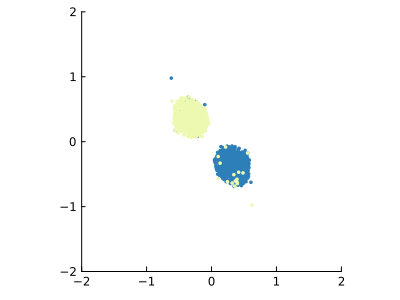

In [986]:
# Choose with snapshot to plot. You can get different snapshots by putting in different indices
# to the history array. `end` just chooses the last entry.
sys_to_plot = history[end]

plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=2)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(sys_to_plot[1],markerstrokewidth=0, markersize=2, marker_z = -1, color= cgrad(:YlGnBu_3,rev=true))

# This plots patch number 2
plot!(sys_to_plot[2],markerstrokewidth=0, markersize=2, marker_z = 1, color= cgrad(:YlGnBu_3,rev=true))


# If you want to save a figure, you can use the savefig function
#savefig("FigName.pdf") 

### Plotting the pathlines of the vortex elements

Below we define a function that allows us to pick off the trajectory of a certain point vortex from ther collected `track` array. We specify it by its patch number and its ID number in the patch

In [987]:
function trajectory(history,patch::Int,elementID::Int)
    elementID > length(history[end][patch]) && error("Element ID out of range")
    track = map(sys -> Elements.position(sys[patch])[elementID],history)
end

trajectory (generic function with 1 method)

Let us plot the trajectory of one point vortex:

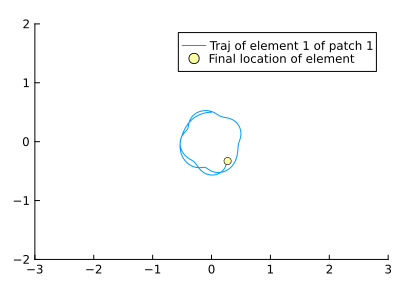

In [988]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(history,patch,elementID)
plot!(ps,real.(traj),imag.(traj),label="Traj of element "*string(elementID)*" of patch "*string(patch));
plot!(ps,history[end][patch][elementID:elementID],legend=true,label="Final location of element")

### Plotting the vortex centroids
The linear impulse of a patch, multiplied by $i$ and divided by the patch's circulation, is the **vortex centroid**. So, plotting the centroid of each patch gives us an idea of where it is. Here, we plot the trajectories of the centroids of patches 1 and 2.

In [989]:
function patch_impulse_history(history,patch::Int)
    imp = map(sys -> Elements.impulse(sys[patch]),history)
end

patch_impulse_history (generic function with 1 method)

In [992]:
cent1 = im*patch_impulse_history(history,1)/Γ01
cent2 = im*patch_impulse_history(history,2)/Γ02

plot(real.(cent1),imag.(cent1),ratio=1,label="Patch 1",legend=true)
plot!(real.(cent2),imag.(cent2),label="Patch 2")

savefig("c_0.02.pdf")

"C:\\Users\\bill\\MAE150A\\MAE250A\\hw5\\c_0.02.pdf"

#### Distance between patch centroids
We can compute the distance between the centroids 

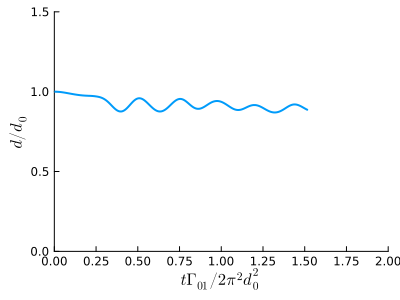

In [991]:
plot(xlim=(0,2),ylim=(0,1.5),xticks=(0:0.25:2),legend=:false)
plot!(Γ01*thist/(2π^2*d0^2),abs.(cent2-cent1),linewidth=2)
plot!(xlabel=L"tΓ_{01}/2π^2d_0^2",ylabel=L"d/d_0") # if this line fails, just comment it out
#savefig("0.02.pdf")